In [1]:
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
from gsw import sigma0
import numpy.ma as ma

import time
import yaml

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '/home1/datahome/mlejeune/cartopy_shapefiles'



In [2]:
d_test = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/test_ds.nc")
d_train = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/train_ds.nc")

In [3]:
d_full = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/full_ds.nc")

### Glorys12

In [4]:
x_glo = xr.open_dataset('/home1/datahome/mlejeune/assets/GLORYS_interp/GLORYS_Interp_Final.nc')
x_glo = x_glo.where(x_glo.depth<1001,drop = True)

In [5]:
#Compute GLORYS RMSE weighted by depth levels
#RMSE function
def rmse_from_ae(ae):
    return np.sqrt(((ae) ** 2).mean(axis=0))

rmse_T = rmse_from_ae(x_glo['ae_to'])
rmse_S = rmse_from_ae(x_glo['ae_so'])
rmse_SIG = rmse_from_ae(x_glo['ae_SIG'])
x_glo = x_glo.assign(variables={"rmse_T": (('depth'), rmse_T.data)})
x_glo = x_glo.assign(variables={"rmse_S": (('depth'), rmse_S.data)})
x_glo = x_glo.assign(variables={"rmse_SIG": (('depth'), rmse_SIG.data)})

#Creation of delta z (shift and add a 46m)
p = x_glo.depth
dz = np.ones(len(p))
for n in np.arange(0,len(p)-1):
    dz[n+1] = p[n+1]-p[n]
dzs = list(dz[1:35])
dzs.append(46.0)
len(dzs)

Trmse_mean = sum(x_glo['rmse_T']*dzs)/(sum(dzs))
Srmse_mean = sum(x_glo['rmse_S']*dzs)/(sum(dzs))
SIGrmse_mean = sum(x_glo['rmse_SIG']*dzs)/(sum(dzs))
x_glo['rmse_SIG']

<xarray.DataArray 'rmse_SIG' (depth: 35)>
array([0.16175983, 0.15130715, 0.14925992, 0.14743759, 0.14157691,
       0.13542293, 0.13233888, 0.12952564, 0.12765193, 0.12732849,
       0.12792874, 0.12807158, 0.12785359, 0.12624799, 0.12635486,
       0.11828642, 0.10987375, 0.09539323, 0.08054576, 0.07142964,
       0.06153101, 0.05247158, 0.04721366, 0.04061246, 0.03743752,
       0.03516627, 0.03253296, 0.02988209, 0.02673747, 0.02315049,
       0.02239345, 0.02146167, 0.01703811, 0.01347662, 0.01104385])
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 3.819 ... 541.1 643.6 763.3 902.3

In [6]:
x_glo = x_glo.assign(variables={"rmse_T_mean": (Trmse_mean)})
x_glo = x_glo.assign(variables={"rmse_S_mean": (Srmse_mean)})
x_glo = x_glo.assign(variables={"rmse_SIG_mean": (SIGrmse_mean)})

In [7]:
#RMSE by year
def rmse(predictions, targets):
    return np.sqrt(np.mean(((predictions - targets) ** 2), axis=0))

rmse_T = []
rmse_S = []
rmse_MLD = []
nb_prof = []
year_list = []
for year in np.unique(x_glo['TIME'].dt.year.data):
    tmp_ds = x_glo.where(x_glo['TIME'].dt.year==year, drop=True)
    year_list.append(year)
    nb_prof.append(len(tmp_ds.N_PROF))
    print(f"year: {year}, nb prof:{len(tmp_ds.N_PROF)}")
    rmse_T.append(rmse(tmp_ds['CT'], tmp_ds['CT_predicted']))
    rmse_S.append(rmse(tmp_ds['SA'], tmp_ds['SA_predicted']))

year: 1993, nb prof:305
year: 1994, nb prof:138


In [22]:
list_to_average = []

for i in range(len(rmse_T[0])):
    tempo_list = []
    for j in range(len(rmse_T)):
        tempo_list.append(rmse_T[j][i].values)
    list_to_average.append(tempo_list)    
    
list_final = []

for k in range(len(list_to_average)):
    somme = 0;
    for l in range(len(list_to_average[0])):
        somme = somme + list_to_average[k][l];
        
    average = somme / len(list_to_average[0])
    list_final.append(average)


In [26]:
list_to_average_salinity = []

for i in range(len(rmse_S[0])):
    tempo_list = []
    for j in range(len(rmse_S)):
        tempo_list.append(rmse_S[j][i].values)
    list_to_average_salinity.append(tempo_list)    
    
list_final_salinity = []

for k in range(len(list_to_average_salinity)):
    somme = 0;
    for l in range(len(list_to_average_salinity[0])):
        somme = somme + list_to_average_salinity[k][l];
        
    average = somme / len(list_to_average[0])
    list_final_salinity.append(average)


### Plot RMSE

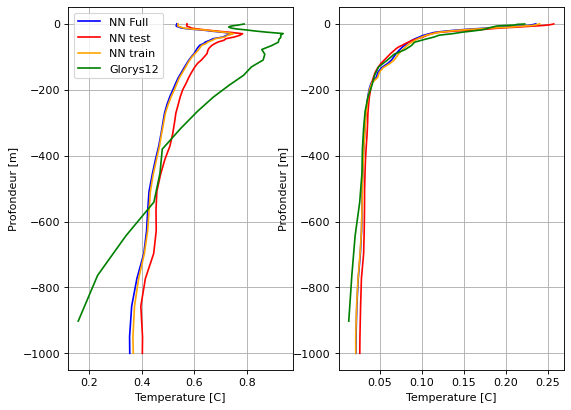

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

ax[0].plot(d_full['rmse_T_model'].mean(axis=0), -d_full['DEPTH'], label='NN Full', c="blue")
ax[0].plot(d_test['rmse_T_model'].mean(axis=0), -d_full['DEPTH'], label='NN test', c="red")
ax[0].plot(d_train['rmse_T_model'].mean(axis=0), -d_full['DEPTH'], label='NN train', c="orange")

ax[0].plot(list_final, -x_glo['depth'], label='Glorys12', c="green")


ax[0].set_xlabel('Temperature [C]')
ax[0].set_ylabel('Profondeur [m]')

ax[1].set_xlabel('Temperature [C]')
ax[1].set_ylabel('Profondeur [m]')

ax[1].plot(d_full['rmse_S_model'].mean(axis=0), -d_full['DEPTH'], label='NN Full', c="blue")
ax[1].plot(d_test['rmse_S_model'].mean(axis=0), -d_full['DEPTH'], label='NN test', c="red")
ax[1].plot(d_train['rmse_S_model'].mean(axis=0), -d_full['DEPTH'], label='NN train', c="orange")

ax[1].plot(list_final_salinity, -x_glo['depth'], label='Glorys12', c="green")


ax[0].grid()
ax[1].grid()
leg = ax[0].legend();
